In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1, 12 + 1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# ENSO & temperature relationship status

## Pick period

In [2]:
start_year = 1980
start_year = 1950
end_year = 2021

start_mon = 'Dec'
end_mon = 'Feb'

start_mon = 'Jun'
end_mon = 'Aug'

# change above ----------------------------

# DL kludge 3 months before
start_mon_DL = np.roll(month_str, 3)[month_str.index(start_mon)]

DL_season = '{}-{}'.format(start_mon, end_mon)
print(DL_season)

DL_range = 'T/({}%20{})/({}%20{})/RANGE/'.format(start_mon_DL, start_year - 1, end_mon, end_year)
print(DL_range)

DL_range_average_select = DL_range + 'T/3/boxAverage/T/%28' + DL_season + '%29/VALUES/'
print(DL_range_average_select)

title_range = ' (' + DL_season + ' ' + str(start_year) + '–' + str(end_year) + ')'
print(title_range)

test_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.BerkeleyEarth/.TAVG/time//T/renameGRID/monthlyAverage/' + DL_range_average_select + 'longitude/-170/-55/RANGE/latitude/14/70/RANGE/dods'
print(test_url)

Jun-Aug
T/(Mar%201949)/(Aug%202021)/RANGE/
T/(Mar%201949)/(Aug%202021)/RANGE/T/3/boxAverage/T/%28Jun-Aug%29/VALUES/
 (Jun-Aug 1950–2021)
http://iridl.ldeo.columbia.edu/home/.tippett/.BerkeleyEarth/.TAVG/time//T/renameGRID/monthlyAverage/T/(Mar%201949)/(Aug%202021)/RANGE/T/3/boxAverage/T/%28Jun-Aug%29/VALUES/longitude/-170/-55/RANGE/latitude/14/70/RANGE/dods


## Read temp 

### GHCN CAMS

In [3]:
temp_url = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.GHCN_CAMS/.gridded/.deg0p5/.temp/monthlyAverage/' + DL_range_average_select + 'X/-170/-55/RANGE/Y/14/70/RANGE/X/-170/1.0/-55/GRID/Y/14/1.0/70/GRID/X//longitude/renameGRID/Y//latitude/renameGRID/dods'
ds = xr.open_dataset(temp_url, decode_times=False)
temp = ds.temp
msk = ~np.isnan(temp.isel(T=0).values)
print(temp_url)

http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.GHCN_CAMS/.gridded/.deg0p5/.temp/monthlyAverage/T/(Mar%201949)/(Aug%202021)/RANGE/T/3/boxAverage/T/%28Jun-Aug%29/VALUES/X/-170/-55/RANGE/Y/14/70/RANGE/X/-170/1.0/-55/GRID/Y/14/1.0/70/GRID/X//longitude/renameGRID/Y//latitude/renameGRID/dods


### Berkeley Earth

In [4]:
temp_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.BerkeleyEarth/.TAVG/time//T/renameGRID/monthlyAverage/' + DL_range_average_select + 'longitude/-170/-55/RANGE/latitude/14/70/RANGE/dods'
ds = xr.open_dataset(temp_url, decode_times=False)
temp = ds.TAVG
msk = ~np.isnan(temp.isel(T=0).values)

In [5]:
lon2, lat2 = np.meshgrid(temp.longitude, temp.latitude)

## Read Nino 3.4

In [6]:
n34_url = 'https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES/%5BX/Y%5Daverage/zlev/removeGRID/' + DL_range_average_select + 'dods'
ds_n34 = xr.open_dataset(n34_url, decode_times=False)
# remove mean
n34 = ds_n34.sst - ds_n34.sst.mean('T')
print(n34_url)

https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES/%5BX/Y%5Daverage/zlev/removeGRID/T/(Mar%201949)/(Aug%202021)/RANGE/T/3/boxAverage/T/%28Jun-Aug%29/VALUES/dods


## Regression!

## Y

In [7]:
N, ny, nx  = temp.shape
Y = temp.values.reshape((N, nx * ny))
print(N)

73


## X

In [8]:
ncoeff = 3
coeff_name = ['Intercept', 'Nino 3.4',  'Trend']
coeff_units = ['deg C', 'deg C / deg Nino 3.4', 'deg C / decade']

X = np.full((N, ncoeff), np.nan)

X[:, 0] = 1
X[:, 1] = n34.values 
# trend values will be deg / decade
X[:, 2] = (n34['T'].values - n34['T'].values[0]) / 12 / 10

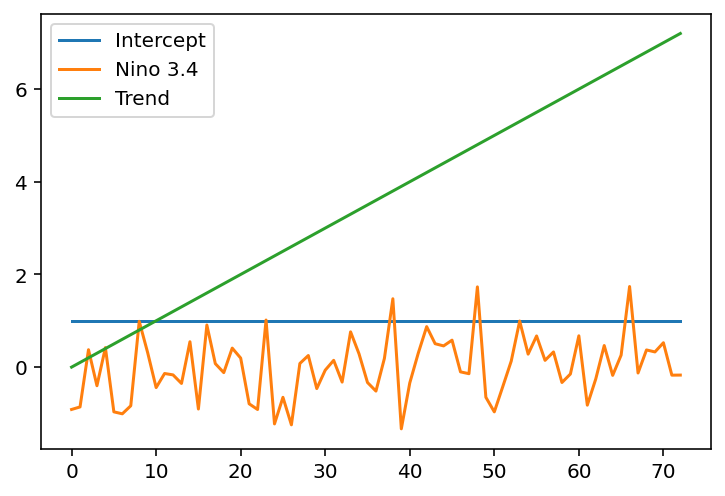

In [9]:
plt.plot(X)
plt.legend(coeff_name)
plt.show()

In [10]:
from numpy.linalg import inv
beta = inv(X.T @ X) @ (X.T@Y)
Yhat = X @ beta

In [11]:
# bootstrap for p-values
mc = 1000
p = np.zeros_like(beta)
p2 = np.zeros((1, ny * nx))
for ii in range(mc):
    idx = np.random.randint(N, size=N)
    beta_fake = inv(X[idx, :].T @ X[idx, :]) @ (X[idx, :].T@Y[idx, :])
    p = p + (beta_fake > 0)
    # the coefficient order is hard coded
    p2 = p2 + ((beta_fake[1, :] - beta_fake[2, :]) > 0)
p = p / mc
p = 2 * np.minimum(p, 1 - p) 
p2 = p2 / mc
p2 = 2 * np.minimum(p2, 1 - p2) 

p = p.reshape((ncoeff, ny, nx))
p2 = p2.reshape((ny, nx))

## Figure

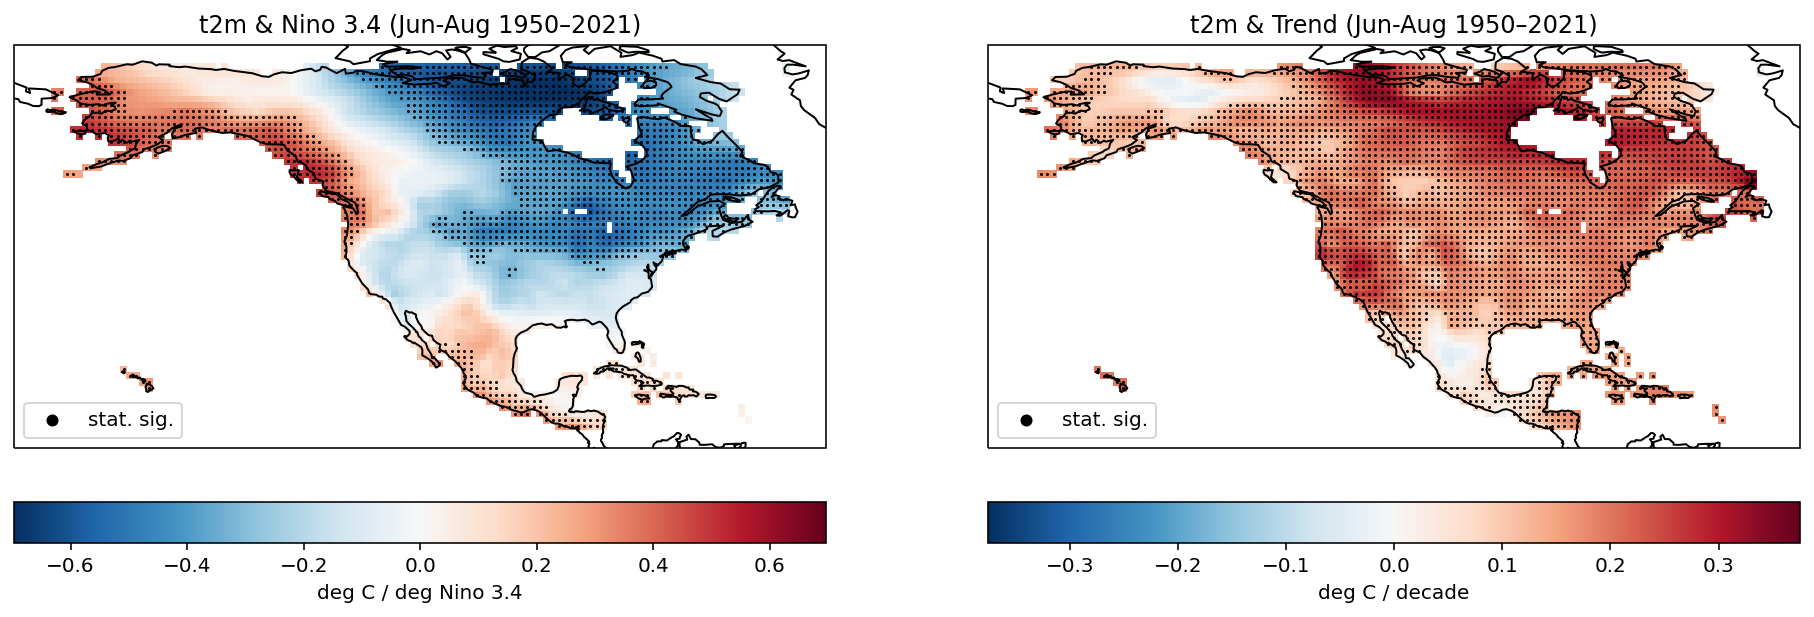

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 10), subplot_kw={'projection': ccrs.PlateCarree()})
for ii,icoeff in enumerate(range(1, ncoeff)):
    ax = axs[ii]
    vmax = np.nanmax(np.abs(beta[icoeff, :]))
    vmin = - vmax
    ax.coastlines()
    g = ax.pcolormesh(temp.longitude, temp.latitude, beta[icoeff, :].reshape((ny, nx)), vmin=vmin, vmax=vmax, cmap='RdBu_r')
    #g = ax.pcolormesh(temp.longitude, temp.latitude, beta[icoeff, :].reshape((ny, nx)), cmap='RdBu_r')
    dot = (p[icoeff, :] < 0.05) & msk
    ax.scatter(x=lon2[dot], y=lat2[dot], c='k', s=1, marker='.', label='stat. sig.')
    title = 't2m & ' + coeff_name[icoeff] + title_range
    ax.set_title(title)
    ax.legend(loc='lower left', markerscale=10)
    plt.colorbar(g, ax=ax, orientation='horizontal', label=coeff_units[icoeff], pad=0.05)

fig.set_facecolor("white")
plt.show()

## Show me the data (in a box)

Look at a box.

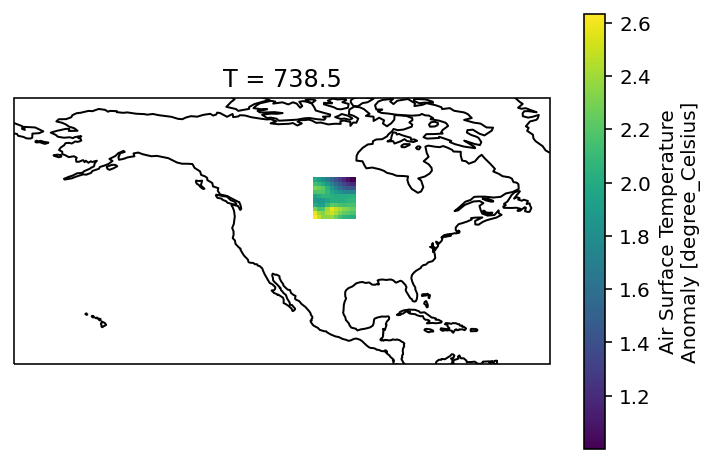

In [13]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

box = (np.abs(temp.latitude - 50) < 5) & (np.abs(temp.longitude + 100) < 5)
temp.isel(T=-1).where(box).plot(ax=ax)
ax.coastlines()
plt.show()

In [14]:
t = temp.where(box).mean(['longitude', 'latitude'])

In [15]:
Y = (t - t.mean('T')).values.reshape(N, 1)

ncoeff = 3
coeff_name = ['Intercept', 'Nino 3.4 > 0', 'Nino 3.4 < 0', 'Trend']
coeff_units = ['deg C', 'deg C / deg Nino 3.4 > 0', 'deg C / deg Nino 3.4 < 0', 'deg C / decade']

X = np.full((N, ncoeff), np.nan)

X[:, 0] = 1
X[:, 1] = n34.values 
# No trend!
X[:, 2] = (n34['T'].values - n34['T'].values[0]) / 12 / 10

beta = inv(X.T @ X) @ (X.T@Y)
Yhat = X @ beta

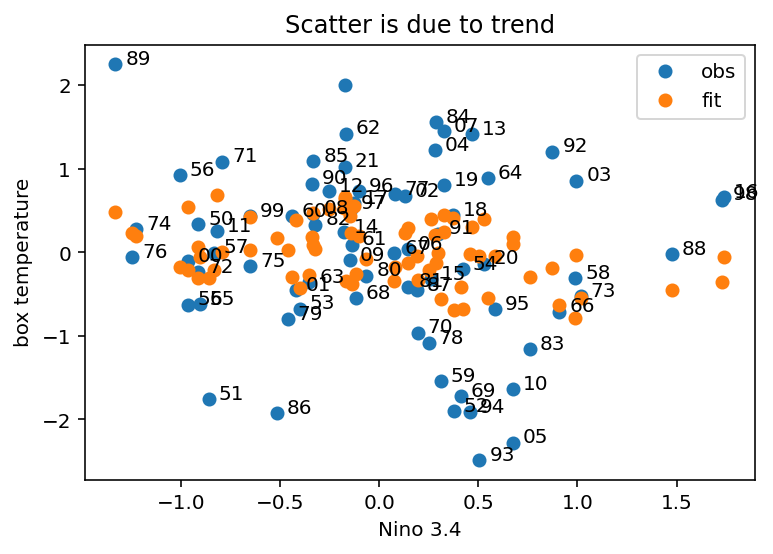

In [16]:
plt.plot(n34, t, 'o', label='obs')
plt.plot(n34, Yhat, 'o', label='fit')
for ii,year in enumerate(np.arange(int(start_year), int(end_year) + 1)):
    plt.text(n34[ii] + 0.05, t[ii], str(year)[2:])
plt.xlabel('Nino 3.4')
plt.ylabel('box temperature')
plt.legend()
plt.title('Scatter is due to trend')
plt.show()

In [17]:
Y = (t - t.mean('T')).values.reshape(N, 1)

ncoeff = 2
coeff_name = ['Intercept', 'Nino 3.4 > 0', 'Nino 3.4 < 0', 'Trend']
coeff_units = ['deg C', 'deg C / deg Nino 3.4 > 0', 'deg C / deg Nino 3.4 < 0', 'deg C / decade']

X = np.full((N, ncoeff), np.nan)

X[:, 0] = 1
X[:, 1] = n34.values 
# No trend!
# X[:, 2] = (n34['T'].values - n34['T'].values[0]) / 12 / 10

beta = inv(X.T @ X) @ (X.T@Y)
Yhat = X @ beta

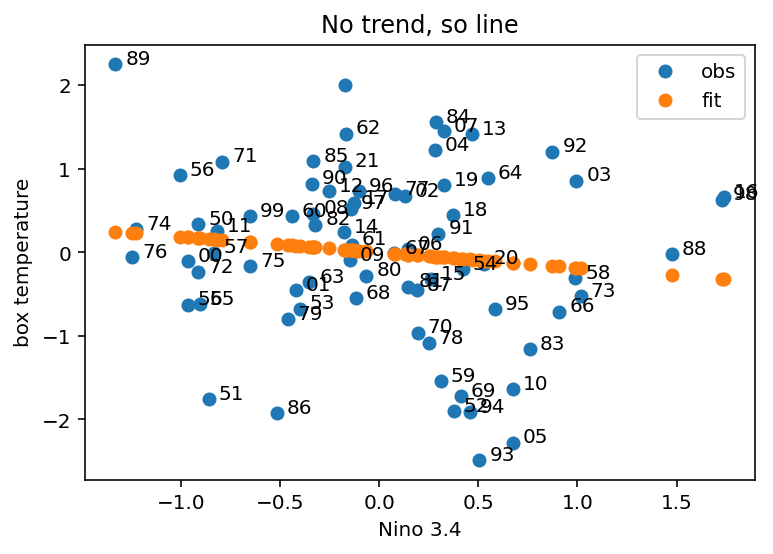

In [18]:
plt.plot(n34, t, 'o', label='obs')
plt.plot(n34, Yhat, 'o', label='fit')
for ii,year in enumerate(np.arange(int(start_year), int(end_year) + 1)):
    plt.text(n34[ii] + 0.05, t[ii], str(year)[2:])
plt.xlabel('Nino 3.4')
plt.ylabel('box temperature')
plt.legend()
plt.title('No trend, so line')
plt.show()